# Tunnel network modeling tutorial
This tutorial will guide you through how to model complex tunnel networks in SHOP and will cover the following topics:
- basic modelling principles for tunnel networks
- creek intakes
- contiuous gates
- pressure and flow constraints
- discrete gates
- gate interlock constraints
- gate switch time

## 1. Basic tunnel network modelling principles
This tutorial will implement the model shown in the topology. The proposed system has three reservoirs, a creek intake and two plants. Both plants are connected to the same tunnel network, but at different positions. The first plant has two generators and discharges the water to the ocean. The second plant has a generator and a pump and discharges to and pumps from reservoir R3. The tunnel network has three gates hence both plants can produce from either one or two reservoirs, and the pump can even pump to R2 while the other plant is producing from R1.

<img src="tunnel_network_topology.png">

We have indicated the intersections connecting multiple tunnels with black dots and named them N1, N2 and N3. Note that these are not represented as explicit objects in SHOP and should not be mixed up with the junction object. The tunnels will follow the naming convention t_{from_node}_{to_node}. For example, t_R1_N1 represents the tunnel from reservoir R1 to node N1. Initially, we defined the necessary objects for our model.

We define functions for the respective steps, for example the function `add_reservoirs(shop)` for creating the reservoir objects in session `shop`. This makes it more convenient to reuse the code in the following sections where we stepwise add more complexity to the model.

In [1]:
# Initialize session and set start and end time
import pandas as pd
from pyshop import ShopSession
def new_model():
    shop = ShopSession()
    starttime = pd.Timestamp('2022-04-16')
    endtime = pd.Timestamp('2022-04-19')
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit='hour')
    return shop

In [2]:
def add_reservoirs(shop):
    rsv1 = shop.model.reservoir.add_object("rsv1")
    rsv1.max_vol.set(12)
    rsv1.lrl.set(90)
    rsv1.hrl.set(100)
    rsv1.vol_head.set(pd.Series([90, 100, 101], index=[0, 12, 14], name=0))
    rsv1.flow_descr.set(pd.Series([0, 1000], index=[100, 101], name=0))

    rsv2 = shop.model.reservoir.add_object("rsv2")
    rsv2.max_vol.set(12)
    rsv2.lrl.set(90)
    rsv2.hrl.set(100)
    rsv2.vol_head.set(pd.Series([90, 100, 101], index=[0, 12, 14], name=0))
    rsv2.flow_descr.set(pd.Series([0, 1000], index=[100, 101], name=0))

    rsv3 = shop.model.reservoir.add_object("rsv3")
    rsv3.max_vol.set(12)
    rsv3.lrl.set(40)
    rsv3.hrl.set(50)
    rsv3.vol_head.set(pd.Series([40, 50, 51], index=[0, 12, 14], name=0))
    rsv3.flow_descr.set(pd.Series([0, 1000], index=[50, 51], name=0))

    rsv3_overflow = shop.model.gate.add_object("rsv3_overflow")
    rsv3.connect_to(rsv3_overflow, "spill")

    creek1 = shop.model.reservoir.add_object("creek1")
    creek1.max_vol.set(0.01)
    creek1.lrl.set(90)
    creek1.hrl.set(110)
    creek1.vol_head.set(pd.Series([90, 110, 111], index=[0, 0.01, 0.02], name=0))
    creek1.flow_descr.set(pd.Series([0, 100], index=[110, 111], name=0))

In [3]:
def add_tunnels(shop):
    t_r1_n1 = shop.model.tunnel.add_object("t_r1_n1")
    t_r1_n1.start_height.set(89)
    t_r1_n1.end_height.set(89)
    t_r1_n1.loss_factor.set(0.001)

    t_c1_n1 = shop.model.tunnel.add_object("t_c1_n1")
    t_c1_n1.start_height.set(89)
    t_c1_n1.end_height.set(89)
    t_c1_n1.loss_factor.set(0.001)

    t_n1_n2 = shop.model.tunnel.add_object("t_n1_n2")
    t_n1_n2.start_height.set(89)
    t_n1_n2.end_height.set(89)
    t_n1_n2.loss_factor.set(0.001)

    t_n2_p1 = shop.model.tunnel.add_object("t_n2_p1")
    t_n2_p1.start_height.set(89)
    t_n2_p1.end_height.set(89)
    t_n2_p1.loss_factor.set(0.001)

    t_r2_n3 = shop.model.tunnel.add_object("t_r2_n3")
    t_r2_n3.start_height.set(89)
    t_r2_n3.end_height.set(89)
    t_r2_n3.loss_factor.set(0.001)

    t_n3_n2 = shop.model.tunnel.add_object("t_n3_n2")
    t_n3_n2.start_height.set(89)
    t_n3_n2.end_height.set(89)
    t_n3_n2.loss_factor.set(0.005)

    t_n3_p2 = shop.model.tunnel.add_object("t_n3_p2")
    t_n3_p2.start_height.set(89)
    t_n3_p2.end_height.set(89)
    t_n3_p2.loss_factor.set(0.001)

In [4]:
def add_plants(shop):
    plant1 = shop.model.plant.add_object("plant1")
    plant1.outlet_line.set(0)
    plant1.main_loss.set([0.0002])
    plant1.penstock_loss.set([0.0001])

    p1g1 = shop.model.generator.add_object("plant1_g1")
    plant1.connect_to(p1g1)
    p1g1.penstock.set(1)
    p1g1.p_min.set(10)
    p1g1.p_max.set(100)
    p1g1.p_nom.set(100)
    p1g1.startcost.set(500)
    p1g1.turb_eff_curves.set([pd.Series([80, 95, 90], index=[10, 90, 100], name=90),
                              pd.Series([82, 97, 92], index=[10, 90, 100], name=100)])

    p1g2 = shop.model.generator.add_object("plant1_g2")
    plant1.connect_to(p1g2)
    p1g2.penstock.set(1)
    p1g2.p_min.set(10)
    p1g2.p_max.set(100)
    p1g2.p_nom.set(100)
    p1g2.startcost.set(500)
    p1g2.turb_eff_curves.set([pd.Series([80, 95, 90], index=[10, 90, 100], name=90),
                              pd.Series([82, 97, 92], index=[10, 90, 100], name=100)])

    plant2 = shop.model.plant.add_object("plant2")
    plant2.outlet_line.set(40)
    plant2.main_loss.set([0.0002])
    plant2.penstock_loss.set([0.0001])

    p2g1 = shop.model.generator.add_object("plant2_g1")
    plant2.connect_to(p2g1)
    p2g1.penstock.set(1)
    p2g1.p_min.set(12)
    p2g1.p_max.set(50)
    p2g1.p_nom.set(50)
    p2g1.startcost.set(500)
    p2g1.turb_eff_curves.set([pd.Series([80, 95, 90], index=[25, 90, 100], name=40),
                              pd.Series([82, 97, 92], index=[25, 90, 100], name=50)])

    p2p1 = shop.model.pump.add_object("plant2_p1")
    plant2.connect_to(p2p1)
    p2p1.penstock.set(1)
    p2p1.p_min.set(12)
    p2p1.p_max.set(50)
    p2p1.p_nom.set(50)
    p2p1.startcost.set(500)
    p2p1.turb_eff_curves.set([pd.Series([80, 95, 90], index=[25, 90, 100], name=40),
                              pd.Series([82, 97, 92], index=[25, 90, 100], name=50)])

In [5]:
def connect_objects(shop):
    shop.model.reservoir.rsv1.connect_to(shop.model.tunnel.t_r1_n1)
    shop.model.reservoir.creek1.connect_to(shop.model.tunnel.t_c1_n1)

    shop.model.tunnel.t_r1_n1.connect_to(shop.model.tunnel.t_n1_n2)
    shop.model.tunnel.t_c1_n1.connect_to(shop.model.tunnel.t_n1_n2)
    shop.model.tunnel.t_n1_n2.connect_to(shop.model.tunnel.t_n2_p1)
    shop.model.tunnel.t_n2_p1.connect_to(shop.model.plant.plant1)

    shop.model.reservoir.rsv2.connect_to(shop.model.tunnel.t_r2_n3)
    shop.model.tunnel.t_r2_n3.connect_to(shop.model.tunnel.t_n3_n2)
    shop.model.tunnel.t_n3_n2.connect_to(shop.model.tunnel.t_n2_p1)

    shop.model.tunnel.t_r2_n3.connect_to(shop.model.tunnel.t_n3_p2)
    shop.model.tunnel.t_n3_p2.connect_to(shop.model.plant.plant2)
    shop.model.plant.plant2.connect_to(shop.model.reservoir.rsv3)

The resulting topology is shown below. Note that the creek intake is modelled as a small reservoir where the volume represents the cross cut from the intake to the tunnel.

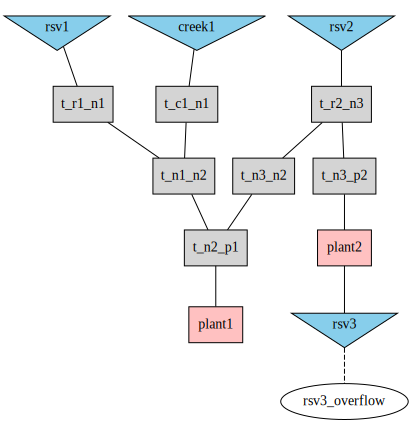

In [6]:
shop = new_model()
add_reservoirs(shop)
add_tunnels(shop)
add_plants(shop)
connect_objects(shop)
shop.model.build_connection_tree()

The model is initialized with historical spot prices from NO1 and higher water value for Reservoir1 than the others.

In [7]:
def init_model(shop):
    time_res = shop.get_time_resolution()
    starttime = time_res['starttime']
    endtime = time_res['endtime']
    
    price = pd.Series(
        [189.13, 187.4, 184.28, 179.79, 178.55, 184.04, 184.96, 185.19, 184.43, 178.41, 172.79, 170, 159.04, 151.02, 145.77, 140.71, 91.15, 151.32, 173.19, 184.14, 187.79, 187.2, 182.7, 172.4, 166.77, 158.86, 148.36, 144.25, 144.55, 144.58, 150.93, 148.77, 153.6, 159.3, 159.86, 161.08, 150.01, 127.22, 97.25, 70.03, 93.64, 107.47, 166.74, 182.45, 185.41, 185.42, 179.99, 163.3, 108.13, 83.68, 86.78, 83.68, 88.07, 95.26, 131.01, 148.91, 144.15, 151.97, 158.76, 153.21, 151.31, 130.02, 50.02, 77.61, 154.46, 175.8, 179.13, 186.71, 194.31, 202.31, 201.25, 195.54, 192.99, 187.38, 185.6, 185.41, 185.97, 192.53, 196.88, 204.7, 285.98, 247.53, 202.89, 193.53, 189.69, 185.28, 182.22, 181.75, 184.18, 189.16, 196.09, 203.57, 206.68, 206.65, 191.96, 185.45],
        index=[starttime+pd.Timedelta(hours=t) for t in range(24*4)]
    )
    price_mean = price.mean()
    
    shop.model.reservoir.rsv1.start_head.set(95)
    shop.model.reservoir.rsv2.start_head.set(95)
    shop.model.reservoir.creek1.start_head.set(95)
    shop.model.reservoir.rsv3.start_head.set(45)

    shop.model.reservoir.rsv1.energy_value_input.set(price_mean)
    shop.model.reservoir.rsv2.energy_value_input.set(0.9*price_mean)
    shop.model.reservoir.rsv3.energy_value_input.set(0.9*price_mean)
    shop.model.reservoir.creek1.energy_value_input.set(price_mean)

    shop.model.reservoir.rsv1.overflow_cost.set(50000)
    shop.model.reservoir.rsv2.overflow_cost.set(50000)
    shop.model.reservoir.rsv3.overflow_cost.set(50000)
    shop.model.reservoir.creek1.overflow_cost.set(50000)
    
    shop.model.market.add_object("spot")
    shop.model.market.spot.buy_price.set(price + 0.01)
    shop.model.market.spot.sale_price.set(price - 0.01)

    shop.model.reservoir.rsv3.inflow.set(50)
init_model(shop)

The model is optimized with 3 full and 3 incremental iterations.

In [8]:
# shop.print_model([], ['full1.lp'])
shop.start_sim([],[3])
shop.set_code(['incremental'], [])
shop.start_sim([],[3])

True

In [9]:
import plotly.graph_objects as go
from IPython.display import HTML

fig = go.Figure()
plant1_prod = shop.model.plant.plant1.production.get()
plant2_prod = shop.model.plant.plant2.production.get()
plant2_cons = shop.model.plant.plant2.consumption.get()
fig.add_trace(go.Scatter(x=plant1_prod.index, y=plant1_prod.values, name="Plant 1 production"))
fig.add_trace(go.Scatter(x=plant2_prod.index, y=plant2_prod.values, name="Plant 2 production"))
fig.add_trace(go.Scatter(x=plant2_cons.index, y=plant2_cons.values, name="Plant 2 consumption"))
fig.update_layout(title="Production and consumption")
fig.show()

fig = go.Figure()
rsv1_head = shop.model.reservoir.rsv1.storage.get()
rsv2_head = shop.model.reservoir.rsv2.storage.get()
rsv3_head = shop.model.reservoir.rsv3.storage.get()
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv1_head.values, name="Rsv 1 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv2_head.values, name="Rsv 2 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv3_head.values, name="Rsv 3 storage"))
fig.update_layout(title="Reservoir storage")
fig.show()

## 2. Tunnel continuous gates
The tunnel object can be equiped with gates to limit the flow, either as a continuous gate which can be opearted contiuously or a binary gate that can be operated at predifined positions. In our example, rsv1 is emptied before rsv2 due to the high loss between node 2 and 3. Therfore, it may be beneficial to limit the flow from rsv1 to increase the consumption from rsv2. We assume there is a continous gate installed below rsv1.

In [10]:
def insert_contiuous_gate(shop):
    shop.model.tunnel.t_r1_n1.gate_opening_curve.set(pd.Series([0,1], index=[0,1]))
    shop.model.tunnel.t_r1_n1.initial_opening.set(1)
    shop.model.tunnel.t_r1_n1.continuous_gate.set(1)

In [11]:
shop = new_model()
add_reservoirs(shop)
add_tunnels(shop)
add_plants(shop)
connect_objects(shop)
init_model(shop)
insert_contiuous_gate(shop)

shop.start_sim([],[3])


fig = go.Figure()
plant1_prod = shop.model.plant.plant1.production.get()
plant2_prod = shop.model.plant.plant2.production.get()
plant2_cons = shop.model.plant.plant2.consumption.get()
fig.add_trace(go.Scatter(x=plant1_prod.index, y=plant1_prod.values, name="Plant 1 production"))
fig.add_trace(go.Scatter(x=plant2_prod.index, y=plant2_prod.values, name="Plant 2 production"))
fig.add_trace(go.Scatter(x=plant2_cons.index, y=plant2_cons.values, name="Plant 2 consumption"))
fig.update_layout(title="Production and consumption")
fig.show()

fig = go.Figure()
rsv1_head = shop.model.reservoir.rsv1.storage.get()
rsv2_head = shop.model.reservoir.rsv2.storage.get()
rsv3_head = shop.model.reservoir.rsv3.storage.get()
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv1_head.values, name="Rsv 1 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv2_head.values, name="Rsv 2 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv3_head.values, name="Rsv 3 storage"))
fig.update_layout(title="Reservoir storage")
fig.show()

fig = go.Figure()
gate = shop.model.tunnel.t_r1_n1.gate_opening.get()
fig.add_trace(go.Scatter(x=gate.index, y=gate.values, name="Rsv 1 gate position"))
fig.update_layout(title="Gate postion")
fig.show()

In [12]:
shop.set_code(['incremental'], [])
shop.print_model([], ['model_inc1.lp'])
shop.start_sim([],[3])

fig = go.Figure()
plant1_prod = shop.model.plant.plant1.production.get()
plant2_prod = shop.model.plant.plant2.production.get()
plant2_cons = shop.model.plant.plant2.consumption.get()
fig.add_trace(go.Scatter(x=plant1_prod.index, y=plant1_prod.values, name="Plant 1 production"))
fig.add_trace(go.Scatter(x=plant2_prod.index, y=plant2_prod.values, name="Plant 2 production"))
fig.add_trace(go.Scatter(x=plant2_cons.index, y=plant2_cons.values, name="Plant 2 consumption"))
fig.update_layout(title="Production and consumption")
fig.show()

fig = go.Figure()
rsv1_head = shop.model.reservoir.rsv1.storage.get()
rsv2_head = shop.model.reservoir.rsv2.storage.get()
rsv3_head = shop.model.reservoir.rsv3.storage.get()
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv1_head.values, name="Rsv 1 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv2_head.values, name="Rsv 2 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv3_head.values, name="Rsv 3 storage"))
fig.update_layout(title="Reservoir storage")
fig.show()

fig = go.Figure()
gate = shop.model.tunnel.t_r1_n1.gate_opening.get()
fig.add_trace(go.Scatter(x=gate.index, y=gate.values, name="Rsv 1 gate position"))
fig.update_layout(title="Gate postion")
fig.show()

## 3. Tunnel discrete gates
Tunnels are often equiped with gates that can either be opened or closed, or operated at a limited number of fixed positions. The allowed positions are given by the points at the gate opening curve. In our example, the gates can either be fully opened or closed. Moreover, there will typically be a limited number of permitted gate position combinations. To avoid air pockets, the tunnel segments should no be depressurized. In our case, only one of the gates should be closed at any time. Therfore, we defined a interlock constraint comprising all gates and set minimum number of open gates to 2 and maximum to 3.

This type of problem requires mixed-integer programming (MIP), hence it is computationally difficult to solve. In our case, we prefer to switch the gates around mid-night and set the adjustment cost to a very high value the other hours to narrow down the MIP search. We also set a cost in the hours where we prefer the switch to occur since it is beneficial for the solution time. Finally, the MIP-gap is set absolute and we use 2 times the switch cost.

In [13]:
def insert_discrete_gate(shop):
    starttime = shop.get_time_resolution()["starttime"]
    adjustment_cost = pd.Series(
        [100000, 500, 100000, 500, 100000],
        index=[starttime, starttime + pd.Timedelta(hours=22), starttime + pd.Timedelta(hours=26), starttime + pd.Timedelta(hours=46), starttime + pd.Timedelta(hours=50)]
    )
    shop.model.tunnel.t_r1_n1.gate_opening_curve.set(pd.Series([0,1], index=[0,1]))
    shop.model.tunnel.t_r1_n1.initial_opening.set(1)
    shop.model.tunnel.t_r1_n1.gate_adjustment_cost.set(adjustment_cost)
    #shop.model.tunnel.t_r1_n1.gate_opening_schedule.set(1)
    
    shop.model.tunnel.t_r2_n3.gate_opening_curve.set(pd.Series([0,1], index=[0,1]))
    shop.model.tunnel.t_r2_n3.initial_opening.set(1)
    shop.model.tunnel.t_r2_n3.gate_adjustment_cost.set(adjustment_cost)
    # shop.model.tunnel.t_r2_n3.gate_opening_schedule.set(1)
    
    shop.model.tunnel.t_n3_n2.gate_opening_curve.set(pd.Series([0,1], index=[0,1]))
    shop.model.tunnel.t_n3_n2.initial_opening.set(1)
    shop.model.tunnel.t_n3_n2.gate_adjustment_cost.set(adjustment_cost)
    # shop.model.tunnel.t_n3_n2.gate_opening_schedule.set(1)
    
    shop.model.interlock_constraint.add_object("Interlock1")
    shop.model.interlock_constraint.Interlock1.connect_to(shop.model.tunnel.t_r1_n1)
    shop.model.interlock_constraint.Interlock1.connect_to(shop.model.tunnel.t_r2_n3)
    shop.model.interlock_constraint.Interlock1.connect_to(shop.model.tunnel.t_n3_n2)
    shop.model.interlock_constraint.Interlock1.min_open.set(2)
    shop.model.interlock_constraint.Interlock1.max_open.set(2)
    shop.model.interlock_constraint.Interlock1.forward_switch_time.set(1)
    shop.model.interlock_constraint.Interlock1.backward_switch_time.set(1)
    
    shop.set_mipgap(["absolute"], [1000])

shop = new_model()
add_reservoirs(shop)
add_tunnels(shop)
add_plants(shop)
connect_objects(shop)
init_model(shop)
insert_discrete_gate(shop)

In [14]:
shop.start_sim([],[3])
shop.set_code(['incremental'], [])
shop.start_sim([],[3])

fig = go.Figure()
plant1_prod = shop.model.plant.plant1.production.get()
plant2_prod = shop.model.plant.plant2.production.get()
plant2_cons = shop.model.plant.plant2.consumption.get()
fig.add_trace(go.Scatter(x=plant1_prod.index, y=plant1_prod.values, name="Plant 1 production"))
fig.add_trace(go.Scatter(x=plant2_prod.index, y=plant2_prod.values, name="Plant 2 production"))
fig.add_trace(go.Scatter(x=plant2_cons.index, y=plant2_cons.values, name="Plant 2 consumption"))
fig.update_layout(title="Production and consumption")
fig.show()

fig = go.Figure()
rsv1_head = shop.model.reservoir.rsv1.storage.get()
rsv2_head = shop.model.reservoir.rsv2.storage.get()
rsv3_head = shop.model.reservoir.rsv3.storage.get()
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv1_head.values, name="Rsv 1 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv2_head.values, name="Rsv 2 storage"))
fig.add_trace(go.Scatter(x=rsv1_head.index, y=rsv3_head.values, name="Rsv 3 storage"))
fig.update_layout(title="Reservoir storage")
fig.show()

fig = go.Figure()
gate1 = shop.model.tunnel.t_r1_n1.gate_opening.get()
fig.add_trace(go.Scatter(x=gate1.index, y=gate1.values, name="Rsv 1 gate position"))
gate2 = shop.model.tunnel.t_r2_n3.gate_opening.get()
fig.add_trace(go.Scatter(x=gate2.index, y=gate2.values, name="Rsv 2 gate position"))
gate3 = shop.model.tunnel.t_n3_n2.gate_opening.get()
fig.add_trace(go.Scatter(x=gate3.index, y=gate3.values, name="N2-3 gate position"))
fig.update_layout(title="Gate postion")
fig.show()